In [1]:
#Este software foi implementado usando um ambiente Debian 9.9,
#com Python 3 na versão 3.5.3, Pandas 0.19.2, NumPy 1.12.1,
#Scikit-Learn 0.18, Matplotlib 2.0.0, Xgboost 0.90 e
#Jupyter Notebook 4.2.3
#Compatibilidade com versões posteriores não é garantida

#carrega as bibliotecas a serem adicionadas

import os
import pandas as pd 
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.neural_network import BernoulliRBM, MLPClassifier

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

#RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

#XGBoost
import xgboost as xgb

#suprimir as warnings
import warnings
warnings.filterwarnings("ignore")

In [47]:
ndxOriginal = pd.read_csv("^NDX.csv",parse_dates=['Date'],index_col='Date')
ndx = ndxOriginal['2010':]
ndx['Var.Day(%)'] = ((ndx['Close']-ndx['Open'])/ndx['Open'])*100

ndx['Class'] = np.where(ndx['Var.Day(%)']>=0,'Alta','Baixa')
ndx['Class'] = ndx['Class'].astype('category')

ndx['OpenPct']  = ndx['Open'].pct_change()
ndx['HighPct']  = ndx['High'].pct_change()
ndx['LowPct']   = ndx['Low'].pct_change()
ndx['ClosePct'] = ndx['Close'].pct_change()

In [3]:
ndxData = ndx[['OpenPct','HighPct','LowPct','ClosePct','Class']].dropna()

n_dias = 30
ndxData = pd.DataFrame(index=ndxData.index)
for i in range(n_dias):
    shiftedValues = ndx[['OpenPct','HighPct','LowPct','ClosePct']].shift(periods=i+1).add_suffix('_d-'+str(i+1))
    ndxData = ndxData.join(shiftedValues)

ndxData = ndxData.join(ndx['Class']).dropna()

train_data = np.array(ndxData[:'2018/01/01'].iloc[:,:-1])
class_data = np.where(ndxData[:'2018/01/01'].iloc[:,-1]=='Alta',1,0)

In [4]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scores={}
n_features = train_data.shape[1]
scale = 1 / (n_features * train_data.var())
for kernelName in kernels:
    clf = SVC(kernel=kernelName,gamma=scale)
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score médio para '+kernelName+": "+str(np.mean(score)))
    scores[kernelName]=score
print(scores)

Score médio para linear: 0.555499720826354
Score médio para poly: 0.5590223846505253
Score médio para rbf: 0.5408811735444902
Score médio para sigmoid: 0.5600350236028627
{'linear': array([0.55527638, 0.55555556, 0.55555556, 0.55555556, 0.55555556]), 'poly': array([0.5678392 , 0.57070707, 0.54545455, 0.55555556, 0.55555556]), 'rbf': array([0.52763819, 0.51767677, 0.53282828, 0.55808081, 0.56818182]), 'sigmoid': array([0.56532663, 0.53787879, 0.5530303 , 0.56818182, 0.57575758])}


In [5]:
clf = RandomForestClassifier()

n_estimators = [int(x) for x in range(50,525,25)]
max_depth = [int(x) for x in range(2,22,2)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_search_param = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
print(random_search_param)

rf_random = RandomizedSearchCV(clf, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
rf_random.fit(train_data, class_data)

{'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [6]:
print(rf_random.best_params_)
clf = rf_random.best_estimator_
score = cross_val_score(clf, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'n_estimators': 425, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'bootstrap': False}
[0.55778894 0.5479798  0.54040404 0.56313131 0.56060606]
0.553982031368966


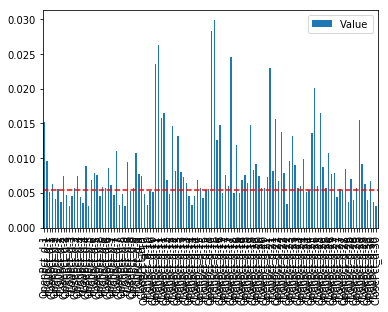

Features com valor acima do threshold:
Index(['OpenPct_d-1', 'HighPct_d-1', 'ClosePct_d-1', 'HighPct_d-2',
       'ClosePct_d-2', 'ClosePct_d-3', 'OpenPct_d-4', 'ClosePct_d-4',
       'HighPct_d-5', 'LowPct_d-5', 'ClosePct_d-5', 'HighPct_d-6',
       'LowPct_d-6', 'ClosePct_d-6', 'OpenPct_d-7', 'LowPct_d-7', 'LowPct_d-8',
       'OpenPct_d-9', 'HighPct_d-9', 'LowPct_d-9', 'ClosePct_d-9',
       'OpenPct_d-11', 'HighPct_d-11', 'LowPct_d-11', 'ClosePct_d-11',
       'OpenPct_d-12', 'LowPct_d-12', 'ClosePct_d-12', 'OpenPct_d-13',
       'HighPct_d-13', 'LowPct_d-13', 'ClosePct_d-13', 'ClosePct_d-14',
       'OpenPct_d-15', 'LowPct_d-15', 'ClosePct_d-15', 'OpenPct_d-16',
       'HighPct_d-16', 'LowPct_d-16', 'ClosePct_d-16', 'HighPct_d-17',
       'LowPct_d-17', 'ClosePct_d-17', 'HighPct_d-18', 'ClosePct_d-18',
       'OpenPct_d-19', 'HighPct_d-19', 'LowPct_d-19', 'ClosePct_d-19',
       'OpenPct_d-20', 'HighPct_d-20', 'LowPct_d-20', 'ClosePct_d-20',
       'OpenPct_d-21', 'HighPct_d-21', 

In [7]:
clf.fit(train_data,class_data)
featureImportance = pd.DataFrame(index=ndxData.iloc[:,:-1].columns)
featureImportance['Value'] = 0

i = 0
for value in clf.feature_importances_:
    featureImportance.iloc[i,0]=value
    i+=1
    
ax = featureImportance.plot(kind='bar')
ax.axhline(y=np.quantile(featureImportance['Value'],0.3),color='r',linestyle='--')
plt.show()
print('Features com valor acima do threshold:')
important = featureImportance[featureImportance['Value']>=np.quantile(featureImportance['Value'],0.3)].index
print(important)

In [8]:
ndxImportant = ndxData[important]

train_data = np.array(ndxImportant.iloc[:,:-1])
class_data = np.where(ndxData.iloc[:,-1]=='Alta',1,0)

In [9]:
kernels = [ 'linear', 'poly', 'rbf', 'sigmoid']
scores={}
scale = 1 / (n_features * train_data.var())
clfSVM = []

X_train, X_test, y_train, y_test = train_test_split(train_data, class_data, test_size=0.3)

for kernelName in kernels:
    clf = SVC(kernel=kernelName,gamma=scale)
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score médio para '+kernelName+": "+str(np.mean(score)))
    scores[kernelName]=score
    clf.fit(X_train,y_train)
    clfSVM.append(clf)
print(scores)

Score médio para linear: 0.5507616391332332
Score médio para poly: 0.5486429950654366
Score médio para rbf: 0.5596474290209541
Score médio para sigmoid: 0.5680737323893299
{'linear': array([0.55063291, 0.55063291, 0.55084746, 0.55084746, 0.55084746]), 'poly': array([0.54852321, 0.55274262, 0.54237288, 0.54872881, 0.55084746]), 'rbf': array([0.55696203, 0.55907173, 0.54237288, 0.5720339 , 0.56779661]), 'sigmoid': array([0.60126582, 0.57172996, 0.55720339, 0.54237288, 0.56779661])}


In [10]:
clf = RandomForestClassifier()
n_estimators = [int(x) for x in range(50,525,25)]
max_depth = [int(x) for x in range(2,22,2)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_search_param = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
print(random_search_param)

rf_random = RandomizedSearchCV(clf, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
rf_random.fit(train_data, class_data)

{'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [11]:
print(rf_random.best_params_)
clfRF = rf_random.best_estimator_
score = cross_val_score(clfRF, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'n_estimators': 325, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 8, 'bootstrap': False}
[0.53586498 0.57383966 0.54237288 0.54025424 0.56355932]
0.5511782164056354


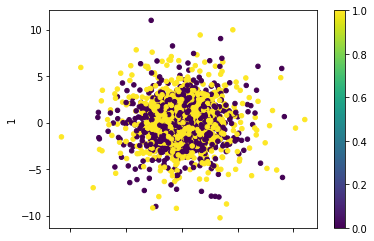

In [12]:
x = StandardScaler().fit_transform(ndxData.iloc[:,:-1])

pca = PCA(n_components=2)
principalComponents = pd.DataFrame(pca.fit_transform(x))

principalComponents.plot(kind='scatter',x=0,y=1,c=class_data,cmap='viridis')
plt.show()

In [13]:
#MLP
clfMLP = MLPClassifier(random_state=1)

solver = ['lbfgs', 'sgd', 'adam']
alpha= [0.1,0.01,0.001,0.0001,0.00001]
hidden_layer_sizes=[(x**2,int((x**2)/2)) for x in range(5,11,1)]

random_search_param = {'solver': solver,
                       'alpha': alpha,
                       'hidden_layer_sizes': hidden_layer_sizes}
print(random_search_param)

MLP_random = RandomizedSearchCV(clfMLP, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
MLP_random.fit(train_data, class_data)

print(MLP_random.best_params_)
clfMLP = MLP_random.best_estimator_
score = cross_val_score(clfMLP, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'hidden_layer_sizes': [(25, 12), (36, 18), (49, 24), (64, 32), (81, 40), (100, 50)]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1231s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.7277s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   34.8s
[Parallel(n_jo

{'solver': 'lbfgs', 'hidden_layer_sizes': (25, 12), 'alpha': 0.1}
[0.57594937 0.56962025 0.54872881 0.53177966 0.54661017]
0.5545376528641922


In [14]:
param_grid = {
        'silent': [True],
        'max_depth': [5, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [int(x) for x in range(50,550,50)],
        'objective': ['binary:logistic']}

fit_params = {'eval_metric': 'auc',
              'early_stopping_rounds': 10,
             'eval_set': [(X_test, y_test)]}

xg_cls_default = xgb.XGBClassifier()

rs_clf = RandomizedSearchCV(xg_cls_default, param_grid, n_iter=250,fit_params=fit_params,
                            n_jobs=-1, verbose=2, cv=3, refit=True, random_state=0)

rs_clf.fit(train_data, class_data)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min


[0]	validation_0-auc:0.702286
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.761696
[2]	validation_0-auc:0.796282
[3]	validation_0-auc:0.826636
[4]	validation_0-auc:0.846994
[5]	validation_0-auc:0.862193
[6]	validation_0-auc:0.872129
[7]	validation_0-auc:0.881851
[8]	validation_0-auc:0.894185
[9]	validation_0-auc:0.902435
[10]	validation_0-auc:0.916007
[11]	validation_0-auc:0.918958
[12]	validation_0-auc:0.925005
[13]	validation_0-auc:0.925092
[14]	validation_0-auc:0.933692
[15]	validation_0-auc:0.938035
[16]	validation_0-auc:0.942331


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  3.1min finished


[17]	validation_0-auc:0.944583
[18]	validation_0-auc:0.946476
[19]	validation_0-auc:0.950653
[20]	validation_0-auc:0.951774
[21]	validation_0-auc:0.955291
[22]	validation_0-auc:0.95646
[23]	validation_0-auc:0.959937
[24]	validation_0-auc:0.962053
[25]	validation_0-auc:0.963087
[26]	validation_0-auc:0.96533
[27]	validation_0-auc:0.967534
[28]	validation_0-auc:0.968067
[29]	validation_0-auc:0.968155
[30]	validation_0-auc:0.967964
[31]	validation_0-auc:0.969817
[32]	validation_0-auc:0.97039
[33]	validation_0-auc:0.970167
[34]	validation_0-auc:0.969642
[35]	validation_0-auc:0.971209
[36]	validation_0-auc:0.972514
[37]	validation_0-auc:0.973485
[38]	validation_0-auc:0.975251
[39]	validation_0-auc:0.975386
[40]	validation_0-auc:0.975354
[41]	validation_0-auc:0.975124
[42]	validation_0-auc:0.976094
[43]	validation_0-auc:0.977566
[44]	validation_0-auc:0.978003
[45]	validation_0-auc:0.977319
[46]	validation_0-auc:0.978123
[47]	validation_0-auc:0.978194
[48]	validation_0-auc:0.9786
[49]	validati

[277]	validation_0-auc:0.999817
[278]	validation_0-auc:0.999833
[279]	validation_0-auc:0.999849
[280]	validation_0-auc:0.999841
[281]	validation_0-auc:0.999849
[282]	validation_0-auc:0.999841
[283]	validation_0-auc:0.999849
[284]	validation_0-auc:0.999849
[285]	validation_0-auc:0.999865
[286]	validation_0-auc:0.999857
[287]	validation_0-auc:0.999857
[288]	validation_0-auc:0.999857
[289]	validation_0-auc:0.999857
[290]	validation_0-auc:0.999857
[291]	validation_0-auc:0.999865
[292]	validation_0-auc:0.999865
[293]	validation_0-auc:0.999865
[294]	validation_0-auc:0.999857
[295]	validation_0-auc:0.999849
Stopping. Best iteration:
[285]	validation_0-auc:0.999865



RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params={'eval_metric': 'auc', 'early_stopping_rounds': 10, 'eval_set': [(array([[ 0.01926,  0.00839, ..., -0.00788, -0.00494],
       [ 0.00864,  0.00296, ...,  0.00136,  0.00476],
       ...,
       [ 0.0149 ,  0.01227, ...,  0.0002 ,  0.00927],
       [ 0.01518,  0.0218 , ..., -0.00893, -0.0089 ]]), array([0, 0, ..., 0, 1]))]},
          iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'silent': [True], 'max_depth': [5, 10, 15, 20], 'learning_rate': [0.001

In [15]:
print(rs_clf.best_params_)
xg_cls = rs_clf.best_estimator_
score = cross_val_score(xg_cls, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'subsample': 0.8, 'silent': True, 'reg_lambda': 0.1, 'objective': 'binary:logistic', 'n_estimators': 450, 'min_child_weight': 7.0, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}
[0.54852321 0.55063291 0.53601695 0.5529661  0.53177966]
0.5439837660015734


In [34]:
#inicialização do Dataframe com os dados de 2019
train_data = np.array(ndxData[important].iloc[:,:-1])
Df = pd.DataFrame(ndx)[ndxData.index[0]:]
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100

#Random Forest
preds = clfRF.predict(train_data)
Df['Predicted_Signal_rf'] = preds
Df['Predicted_Signal_rf'] = Df['Predicted_Signal_rf'].shift(-1)
Df['Strategy_Return_rf'] = Df.Return * Df.Predicted_Signal_rf

#multilayer perceptron
preds = clfMLP.predict(train_data)
Df['Predicted_Signal_mlp'] = preds
Df['Predicted_Signal_mlp'] = Df['Predicted_Signal_mlp'].shift(-1)
Df['Strategy_Return_mlp'] = Df.Return * Df.Predicted_Signal_mlp

#XGBoost Tree
preds = xg_cls.predict_proba(train_data)[:,1]
Df['Predicted_Signal_xg'] = preds>=0.5
Df['Predicted_Signal_xg_safe'] = preds>=0.7
Df['Predicted_Signal_xg_aggro'] = preds>=0.3

Df['Predicted_Signal_xg'] = Df['Predicted_Signal_xg'].shift(-1)
Df['Predicted_Signal_xg_safe'] = Df['Predicted_Signal_xg_safe'].shift(-1)
Df['Predicted_Signal_xg_aggro'] = Df['Predicted_Signal_xg_aggro'].shift(-1)

Df['Strategy_Return_xg'] = Df.Return * Df.Predicted_Signal_xg
Df['Strategy_Return_xg_safe'] = Df.Return * Df.Predicted_Signal_xg_safe
Df['Strategy_Return_xg_aggro'] = Df.Return * Df.Predicted_Signal_xg_aggro

#SVMs
SVMPredict = []
for i,clf in enumerate(clfSVM):
    preds = clf.predict(train_data)
    kernelPredict = 'Strategy_Return_'+kernels[i]
    SVMPredict.append(kernelPredict)
    Df[kernelPredict] = preds
    Df[kernelPredict] = Df.Return * Df[kernelPredict].shift(-1)

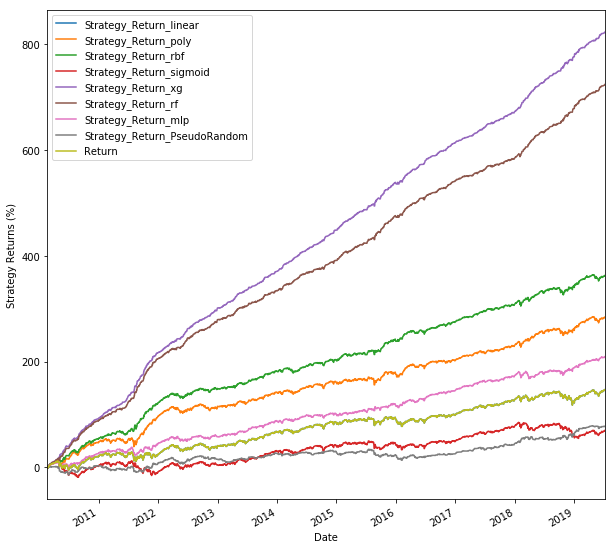

In [35]:
Df['Strategy_Return_PseudoRandom'] = Df.Return * np.random.random_integers(low=0, high=1, size=Df.Return.shape[0])
Df[SVMPredict+['Strategy_Return_xg','Strategy_Return_rf','Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return']].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()

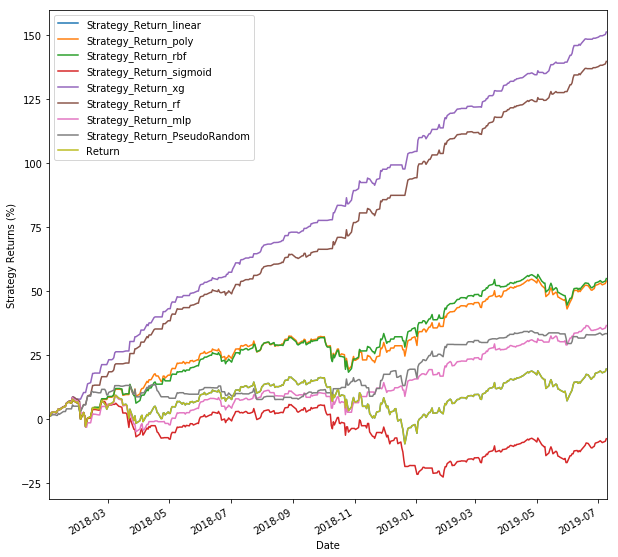

In [36]:
Df[SVMPredict+['Strategy_Return_xg','Strategy_Return_rf','Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return']]['2018':].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()

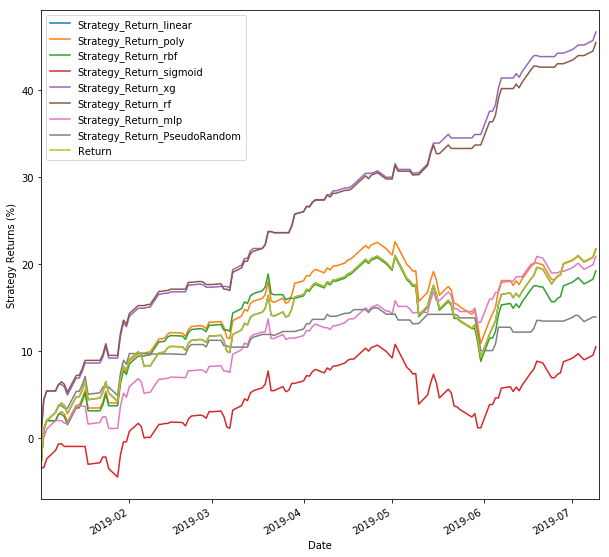

In [37]:
Df[SVMPredict+['Strategy_Return_xg','Strategy_Return_rf','Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return']]['2019':].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()

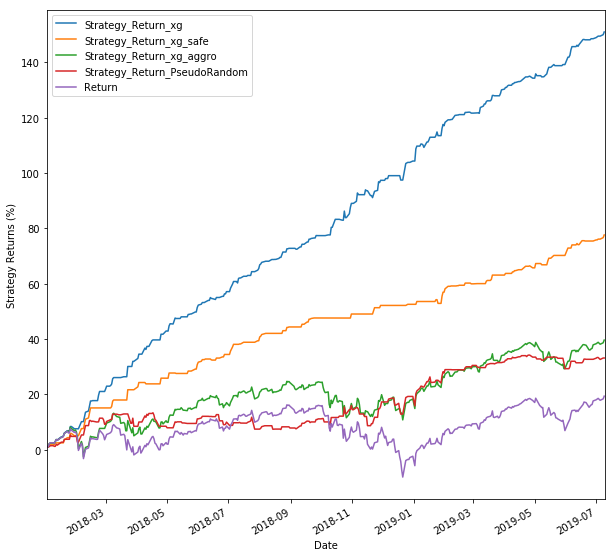

In [38]:
Df[['Strategy_Return_xg','Strategy_Return_xg_safe','Strategy_Return_xg_aggro','Strategy_Return_PseudoRandom','Return']]['2018':].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()

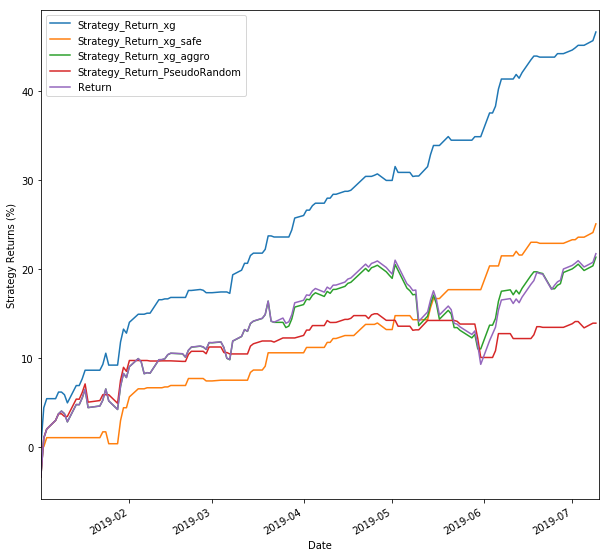

In [39]:
Df[['Strategy_Return_xg','Strategy_Return_xg_safe','Strategy_Return_xg_aggro','Strategy_Return_PseudoRandom','Return']]['2019':].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [98]:
ndxXGB = ndxOriginal
ndxXGB['Var.Day(%)'] = ((ndxXGB['Close']-ndxXGB['Open'])/ndxXGB['Open'])*100

ndxXGB['Class'] = np.where(ndxXGB['Var.Day(%)']>=0,'Alta','Baixa')
ndxXGB['Class'] = ndxXGB['Class'].astype('category')

ndxXGB['OpenPct']  = ndxXGB['Open'].pct_change()
ndxXGB['HighPct']  = ndxXGB['High'].pct_change()
ndxXGB['LowPct']   = ndxXGB['Low'].pct_change()
ndxXGB['ClosePct'] = ndxXGB['Close'].pct_change()

ndxXGBData = ndxXGB[['OpenPct','HighPct','LowPct','ClosePct','Class']].dropna()

n_dias = 30
ndxXGBData = pd.DataFrame(index=ndxXGBData.index)
for i in range(n_dias):
    shiftedValues = ndxXGB[['OpenPct','HighPct','LowPct','ClosePct']].shift(periods=i+1).add_suffix('_d-'+str(i+1))
    ndxXGBData = ndxXGBData.join(shiftedValues)

ndxXGBData = ndxXGBData[important]
ndxXGBData = ndxXGBData.join(ndxXGB['Class']).dropna()

In [121]:
DfXGB = pd.DataFrame(ndx)[ndxData.index[0]:]
DfXGB['Return'] = np.log(DfXGB.Close.shift(-1) / DfXGB.Close)*100
DfXGB['Predicted_Signal_xgb'] = np.nan

dataInicial = pd.to_datetime('2018')
dataFinal = pd.to_datetime('2019/07')
result = []
contador = 0

for dataAtual in pd.date_range(start=dataInicial, end=dataFinal):
    dataSlice = dataAtual-pd.DateOffset(years=10)
    ndxTrain = ndxXGBData[dataSlice:dataAtual].iloc[:-1,:]
    
    X_train, X_test, y_train, y_test = train_test_split(np.array(ndxTrain.iloc[:,:-1]), np.where(ndxTrain.iloc[:,-1]=='Alta',1,0), test_size=0.3)

    xg_cls = xgb.XGBClassifier(silent= False,
                        max_depth= rs_clf.best_params_['max_depth'],
                        learning_rate= rs_clf.best_params_['learning_rate'],
                        subsample= rs_clf.best_params_['subsample'],
                        colsample_bytree= rs_clf.best_params_['colsample_bytree'],
                        colsample_bylevel= rs_clf.best_params_['colsample_bylevel'],
                        min_child_weight= rs_clf.best_params_['min_child_weight'],
                        gamma= rs_clf.best_params_['gamma'],
                        reg_lambda= rs_clf.best_params_['reg_lambda'],
                        n_estimators= rs_clf.best_params_['n_estimators'],
                        objective= rs_clf.best_params_['objective'])
    
    xg_cls.fit(X_train, y_train, eval_metric='auc', verbose=True,
                eval_set=[(X_test, y_test)], early_stopping_rounds=10)
    
    predictedValue = xg_cls.predict(np.array([ndxXGBData[dataSlice:dataAtual].iloc[-1,:-1],]))
    DfXGB['Predicted_Signal_xgb'][dataAtual] = int(predictedValue[0])
    
    correctValue = ndxXGBData[dataSlice:dataAtual].iloc[-1,-1]
    result.append(int(predictedValue[0]) == (1 if correctValue == 'Alta' else 0))
    contador += 1

print(np.sum(result)/contador)
DfXGB['Predicted_Signal_xgb'] = DfXGB['Predicted_Signal_xgb'].shift(-1)

[0]	validation_0-auc:0.522806
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.521029
[2]	validation_0-auc:0.511197
[3]	validation_0-auc:0.495442
[4]	validation_0-auc:0.496659
[5]	validation_0-auc:0.497497
[6]	validation_0-auc:0.491365
[7]	validation_0-auc:0.493361
[8]	validation_0-auc:0.488613
[9]	validation_0-auc:0.493238
[10]	validation_0-auc:0.483333
Stopping. Best iteration:
[0]	validation_0-auc:0.522806

[0]	validation_0-auc:0.514932
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.509482
[2]	validation_0-auc:0.489716
[3]	validation_0-auc:0.493247
[4]	validation_0-auc:0.492935
[5]	validation_0-auc:0.502868
[6]	validation_0-auc:0.507681
[7]	validation_0-auc:0.505425
[8]	validation_0-auc:0.507058
[9]	validation_0-auc:0.50642
[10]	validation_0-auc:0.511136
Stopping. Best iteration:
[0]	validation_0-auc:0.514932

[0]	validation_0-auc:0.489211
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]

[5]	validation_0-auc:0.498019
[6]	validation_0-auc:0.4992
[7]	validation_0-auc:0.509643
[8]	validation_0-auc:0.527541
[9]	validation_0-auc:0.52998
[10]	validation_0-auc:0.531714
[11]	validation_0-auc:0.527809
[12]	validation_0-auc:0.5253
[13]	validation_0-auc:0.520802
[14]	validation_0-auc:0.522705
[15]	validation_0-auc:0.525004
[16]	validation_0-auc:0.528556
[17]	validation_0-auc:0.527242
[18]	validation_0-auc:0.527844
[19]	validation_0-auc:0.523178
[20]	validation_0-auc:0.521817
Stopping. Best iteration:
[10]	validation_0-auc:0.531714

[0]	validation_0-auc:0.4696
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.456251
[2]	validation_0-auc:0.460959
[3]	validation_0-auc:0.480406
[4]	validation_0-auc:0.490898
[5]	validation_0-auc:0.494513
[6]	validation_0-auc:0.488087
[7]	validation_0-auc:0.507302
[8]	validation_0-auc:0.502776
[9]	validation_0-auc:0.506451
[10]	validation_0-auc:0.494109
[11]	validation_0-auc:0.49317
[12]	validation_0-auc:0.497774
[1

[20]	validation_0-auc:0.543273
[21]	validation_0-auc:0.53919
[22]	validation_0-auc:0.538533
[23]	validation_0-auc:0.532622
[24]	validation_0-auc:0.529859
Stopping. Best iteration:
[14]	validation_0-auc:0.555966

[0]	validation_0-auc:0.477644
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.492827
[2]	validation_0-auc:0.494196
[3]	validation_0-auc:0.513324
[4]	validation_0-auc:0.520149
[5]	validation_0-auc:0.524832
[6]	validation_0-auc:0.525243
[7]	validation_0-auc:0.521015
[8]	validation_0-auc:0.521497
[9]	validation_0-auc:0.522828
[10]	validation_0-auc:0.524108
[11]	validation_0-auc:0.522334
[12]	validation_0-auc:0.525811
[13]	validation_0-auc:0.527045
[14]	validation_0-auc:0.531004
[15]	validation_0-auc:0.534644
[16]	validation_0-auc:0.525832
[17]	validation_0-auc:0.525151
[18]	validation_0-auc:0.522852
[19]	validation_0-auc:0.516761
[20]	validation_0-auc:0.512764
[21]	validation_0-auc:0.510763
[22]	validation_0-auc:0.512196
[23]	validation_0-auc

[35]	validation_0-auc:0.534525
[36]	validation_0-auc:0.53326
[37]	validation_0-auc:0.53483
[38]	validation_0-auc:0.534976
[39]	validation_0-auc:0.535171
[40]	validation_0-auc:0.531023
[41]	validation_0-auc:0.526469
[42]	validation_0-auc:0.525851
Stopping. Best iteration:
[32]	validation_0-auc:0.540421

[0]	validation_0-auc:0.55131
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.551614
[2]	validation_0-auc:0.517696
[3]	validation_0-auc:0.523363
[4]	validation_0-auc:0.52161
[5]	validation_0-auc:0.533117
[6]	validation_0-auc:0.529564
[7]	validation_0-auc:0.545289
[8]	validation_0-auc:0.549489
[9]	validation_0-auc:0.548616
[10]	validation_0-auc:0.541915
[11]	validation_0-auc:0.534841
Stopping. Best iteration:
[1]	validation_0-auc:0.551614

[0]	validation_0-auc:0.466579
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.478144
[2]	validation_0-auc:0.485048
[3]	validation_0-auc:0.494339
[4]	validation_0-auc:0.492012
[

[10]	validation_0-auc:0.534295
[11]	validation_0-auc:0.535197
[12]	validation_0-auc:0.542737
[13]	validation_0-auc:0.547955
[14]	validation_0-auc:0.546847
[15]	validation_0-auc:0.549684
[16]	validation_0-auc:0.54991
[17]	validation_0-auc:0.548333
[18]	validation_0-auc:0.550993
[19]	validation_0-auc:0.54875
[20]	validation_0-auc:0.550278
[21]	validation_0-auc:0.54973
[22]	validation_0-auc:0.550993
[23]	validation_0-auc:0.55535
[24]	validation_0-auc:0.555499
[25]	validation_0-auc:0.552514
[26]	validation_0-auc:0.551237
[27]	validation_0-auc:0.553433
[28]	validation_0-auc:0.553058
[29]	validation_0-auc:0.553433
[30]	validation_0-auc:0.553525
[31]	validation_0-auc:0.551375
[32]	validation_0-auc:0.547703
[33]	validation_0-auc:0.549949
[34]	validation_0-auc:0.553419
Stopping. Best iteration:
[24]	validation_0-auc:0.555499

[0]	validation_0-auc:0.496785
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50766
[2]	validation_0-auc:0.497166
[3]	validation_0-a

[3]	validation_0-auc:0.498913
[4]	validation_0-auc:0.504628
[5]	validation_0-auc:0.508874
[6]	validation_0-auc:0.512645
[7]	validation_0-auc:0.514196
[8]	validation_0-auc:0.499614
[9]	validation_0-auc:0.500266
[10]	validation_0-auc:0.493888
[11]	validation_0-auc:0.502921
Stopping. Best iteration:
[1]	validation_0-auc:0.521391

[0]	validation_0-auc:0.51193
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.508256
[2]	validation_0-auc:0.492796
[3]	validation_0-auc:0.496608
[4]	validation_0-auc:0.486175
[5]	validation_0-auc:0.490001
[6]	validation_0-auc:0.493299
[7]	validation_0-auc:0.482584
[8]	validation_0-auc:0.491465
[9]	validation_0-auc:0.488948
[10]	validation_0-auc:0.489824
Stopping. Best iteration:
[0]	validation_0-auc:0.51193

[0]	validation_0-auc:0.490744
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.494735
[2]	validation_0-auc:0.508629
[3]	validation_0-auc:0.50751
[4]	validation_0-auc:0.498672
[5]	vali

[16]	validation_0-auc:0.505434
[17]	validation_0-auc:0.507804
Stopping. Best iteration:
[7]	validation_0-auc:0.516276

[0]	validation_0-auc:0.491043
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.5311
[2]	validation_0-auc:0.523018
[3]	validation_0-auc:0.534814
[4]	validation_0-auc:0.516307
[5]	validation_0-auc:0.513535
[6]	validation_0-auc:0.513489
[7]	validation_0-auc:0.522403
[8]	validation_0-auc:0.523462
[9]	validation_0-auc:0.523469
[10]	validation_0-auc:0.526469
[11]	validation_0-auc:0.528736
[12]	validation_0-auc:0.527372
[13]	validation_0-auc:0.524059
Stopping. Best iteration:
[3]	validation_0-auc:0.534814

[0]	validation_0-auc:0.49074
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.482959
[2]	validation_0-auc:0.492569
[3]	validation_0-auc:0.491433
[4]	validation_0-auc:0.502352
[5]	validation_0-auc:0.518842
[6]	validation_0-auc:0.525523
[7]	validation_0-auc:0.53485
[8]	validation_0-auc:0.536901
[9]	va

[14]	validation_0-auc:0.501888
Stopping. Best iteration:
[4]	validation_0-auc:0.521848

[0]	validation_0-auc:0.498243
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.510361
[2]	validation_0-auc:0.504494
[3]	validation_0-auc:0.498048
[4]	validation_0-auc:0.499074
[5]	validation_0-auc:0.499127
[6]	validation_0-auc:0.49458
[7]	validation_0-auc:0.487771
[8]	validation_0-auc:0.4925
[9]	validation_0-auc:0.488826
[10]	validation_0-auc:0.492713
[11]	validation_0-auc:0.489631
Stopping. Best iteration:
[1]	validation_0-auc:0.510361

[0]	validation_0-auc:0.542993
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.500288
[2]	validation_0-auc:0.501738
[3]	validation_0-auc:0.508537
[4]	validation_0-auc:0.502591
[5]	validation_0-auc:0.50257
[6]	validation_0-auc:0.502676
[7]	validation_0-auc:0.512451
[8]	validation_0-auc:0.505392
[9]	validation_0-auc:0.506892
[10]	validation_0-auc:0.512081
Stopping. Best iteration:
[0]	validati

Stopping. Best iteration:
[24]	validation_0-auc:0.505634

[0]	validation_0-auc:0.524975
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.515822
[2]	validation_0-auc:0.511229
[3]	validation_0-auc:0.519237
[4]	validation_0-auc:0.523904
[5]	validation_0-auc:0.532751
[6]	validation_0-auc:0.547004
[7]	validation_0-auc:0.546546
[8]	validation_0-auc:0.553715
[9]	validation_0-auc:0.549908
[10]	validation_0-auc:0.547674
[11]	validation_0-auc:0.540124
[12]	validation_0-auc:0.538115
[13]	validation_0-auc:0.539278
[14]	validation_0-auc:0.539306
[15]	validation_0-auc:0.539581
[16]	validation_0-auc:0.538623
[17]	validation_0-auc:0.536769
[18]	validation_0-auc:0.538312
Stopping. Best iteration:
[8]	validation_0-auc:0.553715

[0]	validation_0-auc:0.511213
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.516081
[2]	validation_0-auc:0.500032
[3]	validation_0-auc:0.502361
[4]	validation_0-auc:0.505889
[5]	validation_0-auc:0.51628

[2]	validation_0-auc:0.501505
[3]	validation_0-auc:0.488254
[4]	validation_0-auc:0.488115
[5]	validation_0-auc:0.490427
[6]	validation_0-auc:0.490612
[7]	validation_0-auc:0.486343
[8]	validation_0-auc:0.492706
[9]	validation_0-auc:0.488372
[10]	validation_0-auc:0.495317
[11]	validation_0-auc:0.494771
[12]	validation_0-auc:0.502047
[13]	validation_0-auc:0.50132
[14]	validation_0-auc:0.497196
[15]	validation_0-auc:0.499322
[16]	validation_0-auc:0.498352
[17]	validation_0-auc:0.498748
[18]	validation_0-auc:0.506945
[19]	validation_0-auc:0.511054
[20]	validation_0-auc:0.51044
[21]	validation_0-auc:0.505935
[22]	validation_0-auc:0.507448
[23]	validation_0-auc:0.508553
[24]	validation_0-auc:0.507005
[25]	validation_0-auc:0.509409
[26]	validation_0-auc:0.508396
[27]	validation_0-auc:0.509434
[28]	validation_0-auc:0.512962
[29]	validation_0-auc:0.51584
[30]	validation_0-auc:0.517549
[31]	validation_0-auc:0.514974
[32]	validation_0-auc:0.519111
[33]	validation_0-auc:0.519482
[34]	validation_0-a

[14]	validation_0-auc:0.53179
[15]	validation_0-auc:0.527532
[16]	validation_0-auc:0.532612
[17]	validation_0-auc:0.52607
[18]	validation_0-auc:0.527089
[19]	validation_0-auc:0.531769
[20]	validation_0-auc:0.530525
[21]	validation_0-auc:0.534376
[22]	validation_0-auc:0.52723
Stopping. Best iteration:
[12]	validation_0-auc:0.53602

[0]	validation_0-auc:0.523682
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.520059
[2]	validation_0-auc:0.514755
[3]	validation_0-auc:0.528076
[4]	validation_0-auc:0.532026
[5]	validation_0-auc:0.512467
[6]	validation_0-auc:0.514924
[7]	validation_0-auc:0.521942
[8]	validation_0-auc:0.515574
[9]	validation_0-auc:0.517472
[10]	validation_0-auc:0.520698
[11]	validation_0-auc:0.523127
[12]	validation_0-auc:0.525809
[13]	validation_0-auc:0.522231
[14]	validation_0-auc:0.524592
Stopping. Best iteration:
[4]	validation_0-auc:0.532026

[0]	validation_0-auc:0.519719
Will train until validation_0-auc hasn't improved in 10 round

[29]	validation_0-auc:0.541926
Stopping. Best iteration:
[19]	validation_0-auc:0.550231

[0]	validation_0-auc:0.504555
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.510286
[2]	validation_0-auc:0.487643
[3]	validation_0-auc:0.480347
[4]	validation_0-auc:0.46774
[5]	validation_0-auc:0.464753
[6]	validation_0-auc:0.476658
[7]	validation_0-auc:0.488627
[8]	validation_0-auc:0.490958
[9]	validation_0-auc:0.482304
[10]	validation_0-auc:0.484599
[11]	validation_0-auc:0.488698
Stopping. Best iteration:
[1]	validation_0-auc:0.510286

[0]	validation_0-auc:0.484757
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.488013
[2]	validation_0-auc:0.502581
[3]	validation_0-auc:0.508555
[4]	validation_0-auc:0.51817
[5]	validation_0-auc:0.523013
[6]	validation_0-auc:0.523483
[7]	validation_0-auc:0.523763
[8]	validation_0-auc:0.538373
[9]	validation_0-auc:0.542774
[10]	validation_0-auc:0.547211
[11]	validation_0-auc:0.541544
[12]

[1]	validation_0-auc:0.493983
[2]	validation_0-auc:0.508068
[3]	validation_0-auc:0.506485
[4]	validation_0-auc:0.499493
[5]	validation_0-auc:0.49937
[6]	validation_0-auc:0.508093
[7]	validation_0-auc:0.512734
[8]	validation_0-auc:0.516763
[9]	validation_0-auc:0.504254
[10]	validation_0-auc:0.507727
[11]	validation_0-auc:0.507762
[12]	validation_0-auc:0.513434
[13]	validation_0-auc:0.518065
[14]	validation_0-auc:0.51955
[15]	validation_0-auc:0.515925
[16]	validation_0-auc:0.517248
[17]	validation_0-auc:0.521175
[18]	validation_0-auc:0.526728
[19]	validation_0-auc:0.530647
[20]	validation_0-auc:0.533061
[21]	validation_0-auc:0.535595
[22]	validation_0-auc:0.533293
[23]	validation_0-auc:0.532998
[24]	validation_0-auc:0.534778
[25]	validation_0-auc:0.531133
[26]	validation_0-auc:0.526481
[27]	validation_0-auc:0.526671
[28]	validation_0-auc:0.522899
[29]	validation_0-auc:0.524842
[30]	validation_0-auc:0.523747
[31]	validation_0-auc:0.521502
Stopping. Best iteration:
[21]	validation_0-auc:0.

[2]	validation_0-auc:0.522218
[3]	validation_0-auc:0.526128
[4]	validation_0-auc:0.531334
[5]	validation_0-auc:0.530619
[6]	validation_0-auc:0.530173
[7]	validation_0-auc:0.540273
[8]	validation_0-auc:0.531476
[9]	validation_0-auc:0.535786
[10]	validation_0-auc:0.532743
[11]	validation_0-auc:0.542468
[12]	validation_0-auc:0.54584
[13]	validation_0-auc:0.543211
[14]	validation_0-auc:0.543041
[15]	validation_0-auc:0.539615
[16]	validation_0-auc:0.538819
[17]	validation_0-auc:0.536954
[18]	validation_0-auc:0.539198
[19]	validation_0-auc:0.541873
[20]	validation_0-auc:0.547999
[21]	validation_0-auc:0.551627
[22]	validation_0-auc:0.555219
[23]	validation_0-auc:0.555215
[24]	validation_0-auc:0.559908
[25]	validation_0-auc:0.561245
[26]	validation_0-auc:0.561238
[27]	validation_0-auc:0.559172
[28]	validation_0-auc:0.558619
[29]	validation_0-auc:0.555643
[30]	validation_0-auc:0.553148
[31]	validation_0-auc:0.553785
[32]	validation_0-auc:0.557176
[33]	validation_0-auc:0.556362
[34]	validation_0

[56]	validation_0-auc:0.557542
[57]	validation_0-auc:0.557064
[58]	validation_0-auc:0.55801
[59]	validation_0-auc:0.557739
[60]	validation_0-auc:0.559329
[61]	validation_0-auc:0.55743
[62]	validation_0-auc:0.556438
[63]	validation_0-auc:0.555538
[64]	validation_0-auc:0.553151
Stopping. Best iteration:
[54]	validation_0-auc:0.561635

[0]	validation_0-auc:0.522053
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.529899
[2]	validation_0-auc:0.538894
[3]	validation_0-auc:0.549723
[4]	validation_0-auc:0.549057
[5]	validation_0-auc:0.545322
[6]	validation_0-auc:0.540714
[7]	validation_0-auc:0.54437
[8]	validation_0-auc:0.541842
[9]	validation_0-auc:0.538743
[10]	validation_0-auc:0.534366
[11]	validation_0-auc:0.54144
[12]	validation_0-auc:0.537865
[13]	validation_0-auc:0.540555
Stopping. Best iteration:
[3]	validation_0-auc:0.549723

[0]	validation_0-auc:0.49031
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.491736

[13]	validation_0-auc:0.571369
[14]	validation_0-auc:0.568938
[15]	validation_0-auc:0.570415
[16]	validation_0-auc:0.574177
[17]	validation_0-auc:0.576998
[18]	validation_0-auc:0.580216
[19]	validation_0-auc:0.5821
[20]	validation_0-auc:0.584508
[21]	validation_0-auc:0.589035
[22]	validation_0-auc:0.583101
[23]	validation_0-auc:0.582957
[24]	validation_0-auc:0.584943
[25]	validation_0-auc:0.58142
[26]	validation_0-auc:0.575959
[27]	validation_0-auc:0.571152
[28]	validation_0-auc:0.56939
[29]	validation_0-auc:0.570197
[30]	validation_0-auc:0.571959
[31]	validation_0-auc:0.573643
Stopping. Best iteration:
[21]	validation_0-auc:0.589035

[0]	validation_0-auc:0.460127
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.465451
[2]	validation_0-auc:0.447485
[3]	validation_0-auc:0.471434
[4]	validation_0-auc:0.469968
[5]	validation_0-auc:0.478357
[6]	validation_0-auc:0.475033
[7]	validation_0-auc:0.468249
[8]	validation_0-auc:0.479528
[9]	validation_0-auc:0.

[2]	validation_0-auc:0.494529
[3]	validation_0-auc:0.506308
[4]	validation_0-auc:0.513477
[5]	validation_0-auc:0.514382
[6]	validation_0-auc:0.507864
[7]	validation_0-auc:0.503847
[8]	validation_0-auc:0.499085
[9]	validation_0-auc:0.499281
[10]	validation_0-auc:0.502557
Stopping. Best iteration:
[0]	validation_0-auc:0.521876

[0]	validation_0-auc:0.488075
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.471633
[2]	validation_0-auc:0.466934
[3]	validation_0-auc:0.472237
[4]	validation_0-auc:0.483512
[5]	validation_0-auc:0.490672
[6]	validation_0-auc:0.488004
[7]	validation_0-auc:0.506773
[8]	validation_0-auc:0.51653
[9]	validation_0-auc:0.508059
[10]	validation_0-auc:0.496039
[11]	validation_0-auc:0.504755
[12]	validation_0-auc:0.505947
[13]	validation_0-auc:0.508629
[14]	validation_0-auc:0.508952
[15]	validation_0-auc:0.508404
[16]	validation_0-auc:0.506604
[17]	validation_0-auc:0.506049
[18]	validation_0-auc:0.506611
Stopping. Best iteration:
[8]	

[19]	validation_0-auc:0.518001
[20]	validation_0-auc:0.519541
[21]	validation_0-auc:0.518674
[22]	validation_0-auc:0.520716
[23]	validation_0-auc:0.524771
[24]	validation_0-auc:0.523109
[25]	validation_0-auc:0.520456
[26]	validation_0-auc:0.522695
[27]	validation_0-auc:0.521004
[28]	validation_0-auc:0.52441
[29]	validation_0-auc:0.525957
[30]	validation_0-auc:0.526592
[31]	validation_0-auc:0.528146
[32]	validation_0-auc:0.52856
[33]	validation_0-auc:0.529641
[34]	validation_0-auc:0.529262
[35]	validation_0-auc:0.529564
[36]	validation_0-auc:0.528392
[37]	validation_0-auc:0.528918
[38]	validation_0-auc:0.530995
[39]	validation_0-auc:0.532598
[40]	validation_0-auc:0.52896
[41]	validation_0-auc:0.530476
[42]	validation_0-auc:0.53197
[43]	validation_0-auc:0.534237
[44]	validation_0-auc:0.535415
[45]	validation_0-auc:0.538945
[46]	validation_0-auc:0.542537
[47]	validation_0-auc:0.541197
[48]	validation_0-auc:0.539646
[49]	validation_0-auc:0.538075
[50]	validation_0-auc:0.542249
[51]	validat

Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.543367
[2]	validation_0-auc:0.527465
[3]	validation_0-auc:0.542175
[4]	validation_0-auc:0.543335
[5]	validation_0-auc:0.542005
[6]	validation_0-auc:0.535005
[7]	validation_0-auc:0.535546
[8]	validation_0-auc:0.52999
[9]	validation_0-auc:0.539209
[10]	validation_0-auc:0.535169
[11]	validation_0-auc:0.53514
Stopping. Best iteration:
[1]	validation_0-auc:0.543367

[0]	validation_0-auc:0.519856
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.506179
[2]	validation_0-auc:0.500113
[3]	validation_0-auc:0.491307
[4]	validation_0-auc:0.507417
[5]	validation_0-auc:0.515116
[6]	validation_0-auc:0.51086
[7]	validation_0-auc:0.513412
[8]	validation_0-auc:0.512995
[9]	validation_0-auc:0.516922
[10]	validation_0-auc:0.511036
Stopping. Best iteration:
[0]	validation_0-auc:0.519856

[0]	validation_0-auc:0.506279
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	

[0]	validation_0-auc:0.520348
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.529426
[2]	validation_0-auc:0.520889
[3]	validation_0-auc:0.525797
[4]	validation_0-auc:0.526739
[5]	validation_0-auc:0.536371
[6]	validation_0-auc:0.531566
[7]	validation_0-auc:0.525285
[8]	validation_0-auc:0.533947
[9]	validation_0-auc:0.531388
[10]	validation_0-auc:0.534175
[11]	validation_0-auc:0.527755
[12]	validation_0-auc:0.523689
[13]	validation_0-auc:0.523142
[14]	validation_0-auc:0.523647
[15]	validation_0-auc:0.524756
Stopping. Best iteration:
[5]	validation_0-auc:0.536371

[0]	validation_0-auc:0.51583
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.534237
[2]	validation_0-auc:0.522618
[3]	validation_0-auc:0.518576
[4]	validation_0-auc:0.510066
[5]	validation_0-auc:0.520415
[6]	validation_0-auc:0.523094
[7]	validation_0-auc:0.513084
[8]	validation_0-auc:0.506293
[9]	validation_0-auc:0.512188
[10]	validation_0-auc:0.512103

[7]	validation_0-auc:0.509188
[8]	validation_0-auc:0.505559
[9]	validation_0-auc:0.503484
[10]	validation_0-auc:0.501705
[11]	validation_0-auc:0.510402
[12]	validation_0-auc:0.511496
[13]	validation_0-auc:0.511086
[14]	validation_0-auc:0.508065
[15]	validation_0-auc:0.510239
[16]	validation_0-auc:0.513977
[17]	validation_0-auc:0.518223
[18]	validation_0-auc:0.515223
[19]	validation_0-auc:0.521111
[20]	validation_0-auc:0.519423
[21]	validation_0-auc:0.517373
[22]	validation_0-auc:0.522522
[23]	validation_0-auc:0.522438
[24]	validation_0-auc:0.52325
[25]	validation_0-auc:0.524245
[26]	validation_0-auc:0.522184
[27]	validation_0-auc:0.520878
[28]	validation_0-auc:0.522226
[29]	validation_0-auc:0.52433
[30]	validation_0-auc:0.526701
[31]	validation_0-auc:0.528805
[32]	validation_0-auc:0.526419
[33]	validation_0-auc:0.524548
[34]	validation_0-auc:0.523994
[35]	validation_0-auc:0.524231
[36]	validation_0-auc:0.524202
[37]	validation_0-auc:0.524944
[38]	validation_0-auc:0.524686
[39]	validati

[50]	validation_0-auc:0.559515
[51]	validation_0-auc:0.558882
[52]	validation_0-auc:0.558947
[53]	validation_0-auc:0.559566
[54]	validation_0-auc:0.556761
[55]	validation_0-auc:0.556761
[56]	validation_0-auc:0.556387
[57]	validation_0-auc:0.554668
[58]	validation_0-auc:0.555631
[59]	validation_0-auc:0.554171
[60]	validation_0-auc:0.555739
[61]	validation_0-auc:0.556861
[62]	validation_0-auc:0.557919
[63]	validation_0-auc:0.558839
Stopping. Best iteration:
[53]	validation_0-auc:0.559566

[0]	validation_0-auc:0.502431
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.493759
[2]	validation_0-auc:0.485058
[3]	validation_0-auc:0.49238
[4]	validation_0-auc:0.505491
[5]	validation_0-auc:0.519829
[6]	validation_0-auc:0.533712
[7]	validation_0-auc:0.533645
[8]	validation_0-auc:0.538433
[9]	validation_0-auc:0.539115
[10]	validation_0-auc:0.540899
[11]	validation_0-auc:0.534352
[12]	validation_0-auc:0.535977
[13]	validation_0-auc:0.536414
[14]	validation_0-auc

[17]	validation_0-auc:0.500758
[18]	validation_0-auc:0.506386
[19]	validation_0-auc:0.508579
[20]	validation_0-auc:0.513163
[21]	validation_0-auc:0.517268
[22]	validation_0-auc:0.512056
[23]	validation_0-auc:0.512701
[24]	validation_0-auc:0.517476
[25]	validation_0-auc:0.518093
[26]	validation_0-auc:0.51688
[27]	validation_0-auc:0.518121
[28]	validation_0-auc:0.520808
[29]	validation_0-auc:0.5187
[30]	validation_0-auc:0.521542
[31]	validation_0-auc:0.523114
[32]	validation_0-auc:0.525184
[33]	validation_0-auc:0.524073
[34]	validation_0-auc:0.526105
[35]	validation_0-auc:0.528559
[36]	validation_0-auc:0.528051
[37]	validation_0-auc:0.52633
[38]	validation_0-auc:0.523516
[39]	validation_0-auc:0.5248
[40]	validation_0-auc:0.525822
[41]	validation_0-auc:0.525999
[42]	validation_0-auc:0.526105
[43]	validation_0-auc:0.522853
[44]	validation_0-auc:0.518805
[45]	validation_0-auc:0.51962
Stopping. Best iteration:
[35]	validation_0-auc:0.528559

[0]	validation_0-auc:0.474542
Will train until val

[7]	validation_0-auc:0.506962
[8]	validation_0-auc:0.50688
[9]	validation_0-auc:0.514702
[10]	validation_0-auc:0.517485
[11]	validation_0-auc:0.516713
[12]	validation_0-auc:0.516467
[13]	validation_0-auc:0.519465
[14]	validation_0-auc:0.518838
[15]	validation_0-auc:0.51461
[16]	validation_0-auc:0.515864
[17]	validation_0-auc:0.515547
[18]	validation_0-auc:0.515167
[19]	validation_0-auc:0.512211
[20]	validation_0-auc:0.513969
[21]	validation_0-auc:0.514001
[22]	validation_0-auc:0.511933
[23]	validation_0-auc:0.513595
Stopping. Best iteration:
[13]	validation_0-auc:0.519465

[0]	validation_0-auc:0.51189
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.50643
[2]	validation_0-auc:0.492454
[3]	validation_0-auc:0.495716
[4]	validation_0-auc:0.514071
[5]	validation_0-auc:0.519556
[6]	validation_0-auc:0.537841
[7]	validation_0-auc:0.52655
[8]	validation_0-auc:0.521395
[9]	validation_0-auc:0.524119
[10]	validation_0-auc:0.515248
[11]	validation_0-auc:0.5064

[49]	validation_0-auc:0.528699
[50]	validation_0-auc:0.529596
[51]	validation_0-auc:0.530492
[52]	validation_0-auc:0.530316
[53]	validation_0-auc:0.528473
[54]	validation_0-auc:0.527429
[55]	validation_0-auc:0.52464
[56]	validation_0-auc:0.525099
Stopping. Best iteration:
[46]	validation_0-auc:0.533485

[0]	validation_0-auc:0.490356
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.489209
[2]	validation_0-auc:0.496891
[3]	validation_0-auc:0.505832
[4]	validation_0-auc:0.502044
[5]	validation_0-auc:0.509219
[6]	validation_0-auc:0.514456
[7]	validation_0-auc:0.521255
[8]	validation_0-auc:0.515821
[9]	validation_0-auc:0.514234
[10]	validation_0-auc:0.51517
[11]	validation_0-auc:0.521652
[12]	validation_0-auc:0.521223
[13]	validation_0-auc:0.519384
[14]	validation_0-auc:0.525219
[15]	validation_0-auc:0.524681
[16]	validation_0-auc:0.525455
[17]	validation_0-auc:0.528423
[18]	validation_0-auc:0.529232
[19]	validation_0-auc:0.532574
[20]	validation_0-auc:

[10]	validation_0-auc:0.509273
[11]	validation_0-auc:0.511816
[12]	validation_0-auc:0.508362
[13]	validation_0-auc:0.5091
[14]	validation_0-auc:0.512748
[15]	validation_0-auc:0.51468
[16]	validation_0-auc:0.517381
[17]	validation_0-auc:0.521407
[18]	validation_0-auc:0.524854
[19]	validation_0-auc:0.52193
[20]	validation_0-auc:0.522269
[21]	validation_0-auc:0.522329
[22]	validation_0-auc:0.528265
[23]	validation_0-auc:0.529769
[24]	validation_0-auc:0.525426
[25]	validation_0-auc:0.530363
[26]	validation_0-auc:0.53126
[27]	validation_0-auc:0.529798
[28]	validation_0-auc:0.528703
[29]	validation_0-auc:0.531217
[30]	validation_0-auc:0.530942
[31]	validation_0-auc:0.532312
[32]	validation_0-auc:0.531436
[33]	validation_0-auc:0.535942
[34]	validation_0-auc:0.539191
[35]	validation_0-auc:0.535148
[36]	validation_0-auc:0.535052
[37]	validation_0-auc:0.537072
[38]	validation_0-auc:0.534706
[39]	validation_0-auc:0.535709
[40]	validation_0-auc:0.535278
[41]	validation_0-auc:0.536691
[42]	validati

[6]	validation_0-auc:0.5369
[7]	validation_0-auc:0.542421
[8]	validation_0-auc:0.533377
[9]	validation_0-auc:0.526772
[10]	validation_0-auc:0.525905
[11]	validation_0-auc:0.51553
[12]	validation_0-auc:0.514067
[13]	validation_0-auc:0.519997
[14]	validation_0-auc:0.517245
[15]	validation_0-auc:0.522382
[16]	validation_0-auc:0.522248
[17]	validation_0-auc:0.516365
Stopping. Best iteration:
[7]	validation_0-auc:0.542421

[0]	validation_0-auc:0.485706
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.479375
[2]	validation_0-auc:0.483254
[3]	validation_0-auc:0.498651
[4]	validation_0-auc:0.499808
[5]	validation_0-auc:0.511656
[6]	validation_0-auc:0.521665
[7]	validation_0-auc:0.513098
[8]	validation_0-auc:0.521914
[9]	validation_0-auc:0.525708
[10]	validation_0-auc:0.526576
[11]	validation_0-auc:0.529587
[12]	validation_0-auc:0.533573
[13]	validation_0-auc:0.533791
[14]	validation_0-auc:0.534442
[15]	validation_0-auc:0.531196
[16]	validation_0-auc:0.5297

[4]	validation_0-auc:0.526998
[5]	validation_0-auc:0.524145
[6]	validation_0-auc:0.534232
[7]	validation_0-auc:0.532479
[8]	validation_0-auc:0.529998
[9]	validation_0-auc:0.526014
[10]	validation_0-auc:0.527321
[11]	validation_0-auc:0.537394
[12]	validation_0-auc:0.534313
[13]	validation_0-auc:0.542654
[14]	validation_0-auc:0.540195
[15]	validation_0-auc:0.539769
[16]	validation_0-auc:0.532279
[17]	validation_0-auc:0.530452
[18]	validation_0-auc:0.537363
[19]	validation_0-auc:0.540163
[20]	validation_0-auc:0.539878
[21]	validation_0-auc:0.544629
[22]	validation_0-auc:0.546624
[23]	validation_0-auc:0.54264
[24]	validation_0-auc:0.542584
[25]	validation_0-auc:0.541424
[26]	validation_0-auc:0.547239
[27]	validation_0-auc:0.548599
[28]	validation_0-auc:0.549983
[29]	validation_0-auc:0.549484
[30]	validation_0-auc:0.554315
[31]	validation_0-auc:0.546533
[32]	validation_0-auc:0.548866
[33]	validation_0-auc:0.550194
[34]	validation_0-auc:0.554333
[35]	validation_0-auc:0.555106
[36]	validation

[3]	validation_0-auc:0.512131
[4]	validation_0-auc:0.514788
[5]	validation_0-auc:0.497685
[6]	validation_0-auc:0.501542
[7]	validation_0-auc:0.49646
[8]	validation_0-auc:0.500531
[9]	validation_0-auc:0.501051
[10]	validation_0-auc:0.500078
Stopping. Best iteration:
[0]	validation_0-auc:0.519108

[0]	validation_0-auc:0.475744
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.502968
[2]	validation_0-auc:0.500445
[3]	validation_0-auc:0.490721
[4]	validation_0-auc:0.478817
[5]	validation_0-auc:0.484939
[6]	validation_0-auc:0.488289
[7]	validation_0-auc:0.493693
[8]	validation_0-auc:0.48229
[9]	validation_0-auc:0.483523
[10]	validation_0-auc:0.485405
[11]	validation_0-auc:0.479354
Stopping. Best iteration:
[1]	validation_0-auc:0.502968

[0]	validation_0-auc:0.493451
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.493071
[2]	validation_0-auc:0.479653
[3]	validation_0-auc:0.472583
[4]	validation_0-auc:0.496546
[5]	val

[7]	validation_0-auc:0.561875
[8]	validation_0-auc:0.555898
[9]	validation_0-auc:0.561233
[10]	validation_0-auc:0.551966
[11]	validation_0-auc:0.548193
[12]	validation_0-auc:0.553309
[13]	validation_0-auc:0.556867
[14]	validation_0-auc:0.560288
[15]	validation_0-auc:0.553003
[16]	validation_0-auc:0.551973
[17]	validation_0-auc:0.554706
Stopping. Best iteration:
[7]	validation_0-auc:0.561875

[0]	validation_0-auc:0.51897
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.543782
[2]	validation_0-auc:0.531548
[3]	validation_0-auc:0.519728
[4]	validation_0-auc:0.522927
[5]	validation_0-auc:0.522747
[6]	validation_0-auc:0.531654
[7]	validation_0-auc:0.52754
[8]	validation_0-auc:0.527955
[9]	validation_0-auc:0.526495
[10]	validation_0-auc:0.519717
[11]	validation_0-auc:0.512734
Stopping. Best iteration:
[1]	validation_0-auc:0.543782

[0]	validation_0-auc:0.482563
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.517201


[11]	validation_0-auc:0.513296
[12]	validation_0-auc:0.505202
[13]	validation_0-auc:0.5013
[14]	validation_0-auc:0.511115
[15]	validation_0-auc:0.511129
[16]	validation_0-auc:0.513785
[17]	validation_0-auc:0.515754
[18]	validation_0-auc:0.518392
[19]	validation_0-auc:0.5212
[20]	validation_0-auc:0.522411
[21]	validation_0-auc:0.52916
[22]	validation_0-auc:0.533742
[23]	validation_0-auc:0.534819
[24]	validation_0-auc:0.534429
[25]	validation_0-auc:0.537297
[26]	validation_0-auc:0.538501
[27]	validation_0-auc:0.539627
[28]	validation_0-auc:0.539068
[29]	validation_0-auc:0.541766
[30]	validation_0-auc:0.543204
[31]	validation_0-auc:0.541961
[32]	validation_0-auc:0.543062
[33]	validation_0-auc:0.538275
[34]	validation_0-auc:0.542234
[35]	validation_0-auc:0.536299
[36]	validation_0-auc:0.537474
[37]	validation_0-auc:0.534762
[38]	validation_0-auc:0.533749
[39]	validation_0-auc:0.531958
[40]	validation_0-auc:0.532786
Stopping. Best iteration:
[30]	validation_0-auc:0.543204

[0]	validation_0-

[7]	validation_0-auc:0.508822
[8]	validation_0-auc:0.506059
[9]	validation_0-auc:0.505756
[10]	validation_0-auc:0.498809
[11]	validation_0-auc:0.506123
[12]	validation_0-auc:0.51432
[13]	validation_0-auc:0.524619
[14]	validation_0-auc:0.524676
[15]	validation_0-auc:0.525831
[16]	validation_0-auc:0.531117
[17]	validation_0-auc:0.529859
[18]	validation_0-auc:0.516705
[19]	validation_0-auc:0.515281
[20]	validation_0-auc:0.51974
[21]	validation_0-auc:0.521584
[22]	validation_0-auc:0.520136
[23]	validation_0-auc:0.519853
[24]	validation_0-auc:0.518157
[25]	validation_0-auc:0.515479
[26]	validation_0-auc:0.516836
Stopping. Best iteration:
[16]	validation_0-auc:0.531117

[0]	validation_0-auc:0.546879
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.514871
[2]	validation_0-auc:0.500325
[3]	validation_0-auc:0.520308
[4]	validation_0-auc:0.512689
[5]	validation_0-auc:0.513396
[6]	validation_0-auc:0.515175
[7]	validation_0-auc:0.50563
[8]	validation_0-auc:0.5

[19]	validation_0-auc:0.532545
[20]	validation_0-auc:0.532835
[21]	validation_0-auc:0.52491
[22]	validation_0-auc:0.527555
[23]	validation_0-auc:0.527347
[24]	validation_0-auc:0.526026
[25]	validation_0-auc:0.523533
[26]	validation_0-auc:0.517494
[27]	validation_0-auc:0.512642
[28]	validation_0-auc:0.515651
[29]	validation_0-auc:0.514238
[30]	validation_0-auc:0.513243
Stopping. Best iteration:
[20]	validation_0-auc:0.532835

[0]	validation_0-auc:0.524887
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.502993
[2]	validation_0-auc:0.502153
[3]	validation_0-auc:0.515237
[4]	validation_0-auc:0.518841
[5]	validation_0-auc:0.505467
[6]	validation_0-auc:0.50989
[7]	validation_0-auc:0.502234
[8]	validation_0-auc:0.504747
[9]	validation_0-auc:0.505323
[10]	validation_0-auc:0.503124
Stopping. Best iteration:
[0]	validation_0-auc:0.524887

[0]	validation_0-auc:0.505219
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.513

[3]	validation_0-auc:0.462966
[4]	validation_0-auc:0.483848
[5]	validation_0-auc:0.490091
[6]	validation_0-auc:0.486327
[7]	validation_0-auc:0.47977
[8]	validation_0-auc:0.478954
[9]	validation_0-auc:0.480482
[10]	validation_0-auc:0.491067
Stopping. Best iteration:
[0]	validation_0-auc:0.500335

[0]	validation_0-auc:0.512044
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.51824
[2]	validation_0-auc:0.541187
[3]	validation_0-auc:0.526
[4]	validation_0-auc:0.52986
[5]	validation_0-auc:0.511613
[6]	validation_0-auc:0.522873
[7]	validation_0-auc:0.525795
[8]	validation_0-auc:0.525195
[9]	validation_0-auc:0.525132
[10]	validation_0-auc:0.53215
[11]	validation_0-auc:0.528826
[12]	validation_0-auc:0.525322
Stopping. Best iteration:
[2]	validation_0-auc:0.541187

[0]	validation_0-auc:0.479865
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.47113
[2]	validation_0-auc:0.488385
[3]	validation_0-auc:0.4776
[4]	validation

[14]	validation_0-auc:0.509289
[15]	validation_0-auc:0.515801
[16]	validation_0-auc:0.513953
[17]	validation_0-auc:0.509184
[18]	validation_0-auc:0.517398
[19]	validation_0-auc:0.519744
[20]	validation_0-auc:0.511194
[21]	validation_0-auc:0.509163
[22]	validation_0-auc:0.510662
[23]	validation_0-auc:0.50861
[24]	validation_0-auc:0.511649
[25]	validation_0-auc:0.511726
[26]	validation_0-auc:0.509079
[27]	validation_0-auc:0.506285
[28]	validation_0-auc:0.502321
[29]	validation_0-auc:0.505347
Stopping. Best iteration:
[19]	validation_0-auc:0.519744

[0]	validation_0-auc:0.535447
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.519092
[2]	validation_0-auc:0.522742
[3]	validation_0-auc:0.516078
[4]	validation_0-auc:0.528438
[5]	validation_0-auc:0.527891
[6]	validation_0-auc:0.529567
[7]	validation_0-auc:0.536565
[8]	validation_0-auc:0.53148
[9]	validation_0-auc:0.529423
[10]	validation_0-auc:0.536925
[11]	validation_0-auc:0.5333
[12]	validation_0-auc:0.

[26]	validation_0-auc:0.564836
[27]	validation_0-auc:0.559011
[28]	validation_0-auc:0.556245
[29]	validation_0-auc:0.555689
[30]	validation_0-auc:0.553968
[31]	validation_0-auc:0.552849
[32]	validation_0-auc:0.552035
[33]	validation_0-auc:0.551642
[34]	validation_0-auc:0.555321
[35]	validation_0-auc:0.554599
[36]	validation_0-auc:0.553508
Stopping. Best iteration:
[26]	validation_0-auc:0.564836

[0]	validation_0-auc:0.492083
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.48477
[2]	validation_0-auc:0.477416
[3]	validation_0-auc:0.475765
[4]	validation_0-auc:0.502199
[5]	validation_0-auc:0.503797
[6]	validation_0-auc:0.504085
[7]	validation_0-auc:0.510899
[8]	validation_0-auc:0.514734
[9]	validation_0-auc:0.513112
[10]	validation_0-auc:0.519553
[11]	validation_0-auc:0.515943
[12]	validation_0-auc:0.521141
[13]	validation_0-auc:0.522286
[14]	validation_0-auc:0.522742
[15]	validation_0-auc:0.531046
[16]	validation_0-auc:0.527484
[17]	validation_0-auc

[15]	validation_0-auc:0.516708
Stopping. Best iteration:
[5]	validation_0-auc:0.522276

[0]	validation_0-auc:0.487056
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.486219
[2]	validation_0-auc:0.49686
[3]	validation_0-auc:0.495762
[4]	validation_0-auc:0.502151
[5]	validation_0-auc:0.499979
[6]	validation_0-auc:0.496129
[7]	validation_0-auc:0.500646
[8]	validation_0-auc:0.500159
[9]	validation_0-auc:0.49721
[10]	validation_0-auc:0.495932
[11]	validation_0-auc:0.503277
[12]	validation_0-auc:0.50042
[13]	validation_0-auc:0.495508
[14]	validation_0-auc:0.492025
[15]	validation_0-auc:0.495034
[16]	validation_0-auc:0.489108
[17]	validation_0-auc:0.489313
[18]	validation_0-auc:0.485139
[19]	validation_0-auc:0.487703
[20]	validation_0-auc:0.490373
[21]	validation_0-auc:0.491951
Stopping. Best iteration:
[11]	validation_0-auc:0.503277

[0]	validation_0-auc:0.510759
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.5072

[27]	validation_0-auc:0.52788
[28]	validation_0-auc:0.527345
[29]	validation_0-auc:0.523298
[30]	validation_0-auc:0.524271
[31]	validation_0-auc:0.524356
[32]	validation_0-auc:0.523982
[33]	validation_0-auc:0.52277
[34]	validation_0-auc:0.522671
[35]	validation_0-auc:0.520073
[36]	validation_0-auc:0.521331
Stopping. Best iteration:
[26]	validation_0-auc:0.532878

[0]	validation_0-auc:0.509697
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.480247
[2]	validation_0-auc:0.517192
[3]	validation_0-auc:0.534122
[4]	validation_0-auc:0.544245
[5]	validation_0-auc:0.54944
[6]	validation_0-auc:0.552662
[7]	validation_0-auc:0.555179
[8]	validation_0-auc:0.545781
[9]	validation_0-auc:0.556556
[10]	validation_0-auc:0.545835
[11]	validation_0-auc:0.542332
[12]	validation_0-auc:0.540714
[13]	validation_0-auc:0.544267
[14]	validation_0-auc:0.541745
[15]	validation_0-auc:0.547371
[16]	validation_0-auc:0.549654
[17]	validation_0-auc:0.545685
[18]	validation_0-auc:0

[15]	validation_0-auc:0.531514
[16]	validation_0-auc:0.534183
[17]	validation_0-auc:0.533592
[18]	validation_0-auc:0.532739
[19]	validation_0-auc:0.534937
[20]	validation_0-auc:0.529958
[21]	validation_0-auc:0.528877
[22]	validation_0-auc:0.531627
[23]	validation_0-auc:0.532866
[24]	validation_0-auc:0.535225
[25]	validation_0-auc:0.538627
[26]	validation_0-auc:0.543405
[27]	validation_0-auc:0.543155
[28]	validation_0-auc:0.547472
[29]	validation_0-auc:0.549092
[30]	validation_0-auc:0.549472
[31]	validation_0-auc:0.548546
[32]	validation_0-auc:0.551218
[33]	validation_0-auc:0.551173
[34]	validation_0-auc:0.553873
[35]	validation_0-auc:0.553542
[36]	validation_0-auc:0.552535
[37]	validation_0-auc:0.552454
[38]	validation_0-auc:0.553986
[39]	validation_0-auc:0.550831
[40]	validation_0-auc:0.54957
[41]	validation_0-auc:0.54938
[42]	validation_0-auc:0.550257
[43]	validation_0-auc:0.55043
[44]	validation_0-auc:0.551746
[45]	validation_0-auc:0.549437
[46]	validation_0-auc:0.54893
[47]	validat

[20]	validation_0-auc:0.49722
[21]	validation_0-auc:0.498395
[22]	validation_0-auc:0.500061
Stopping. Best iteration:
[12]	validation_0-auc:0.516894

[0]	validation_0-auc:0.491701
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.509743
[2]	validation_0-auc:0.520385
[3]	validation_0-auc:0.514553
[4]	validation_0-auc:0.511302
[5]	validation_0-auc:0.521556
[6]	validation_0-auc:0.523001
[7]	validation_0-auc:0.525134
[8]	validation_0-auc:0.520033
[9]	validation_0-auc:0.524775
[10]	validation_0-auc:0.528208
[11]	validation_0-auc:0.522234
[12]	validation_0-auc:0.526078
[13]	validation_0-auc:0.521847
[14]	validation_0-auc:0.520633
[15]	validation_0-auc:0.52425
[16]	validation_0-auc:0.520147
[17]	validation_0-auc:0.520534
[18]	validation_0-auc:0.519401
[19]	validation_0-auc:0.525159
[20]	validation_0-auc:0.524903
Stopping. Best iteration:
[10]	validation_0-auc:0.528208

[0]	validation_0-auc:0.489481
Will train until validation_0-auc hasn't improved in 10 ro

[20]	validation_0-auc:0.541203
[21]	validation_0-auc:0.540005
[22]	validation_0-auc:0.540097
[23]	validation_0-auc:0.540911
Stopping. Best iteration:
[13]	validation_0-auc:0.549321

[0]	validation_0-auc:0.49366
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.492312
[2]	validation_0-auc:0.496865
[3]	validation_0-auc:0.512217
[4]	validation_0-auc:0.518982
[5]	validation_0-auc:0.507133
[6]	validation_0-auc:0.509907
[7]	validation_0-auc:0.513445
[8]	validation_0-auc:0.503478
[9]	validation_0-auc:0.499674
[10]	validation_0-auc:0.49758
[11]	validation_0-auc:0.503991
[12]	validation_0-auc:0.501854
[13]	validation_0-auc:0.49983
[14]	validation_0-auc:0.503078
Stopping. Best iteration:
[4]	validation_0-auc:0.518982

[0]	validation_0-auc:0.47512
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.495419
[2]	validation_0-auc:0.503638
[3]	validation_0-auc:0.494941
[4]	validation_0-auc:0.517612
[5]	validation_0-auc:0.515275
[6

[8]	validation_0-auc:0.503558
[9]	validation_0-auc:0.51244
[10]	validation_0-auc:0.50706
[11]	validation_0-auc:0.517405
Stopping. Best iteration:
[1]	validation_0-auc:0.545004

[0]	validation_0-auc:0.48215
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.475006
[2]	validation_0-auc:0.457432
[3]	validation_0-auc:0.480095
[4]	validation_0-auc:0.481441
[5]	validation_0-auc:0.4796
[6]	validation_0-auc:0.488433
[7]	validation_0-auc:0.481335
[8]	validation_0-auc:0.481275
[9]	validation_0-auc:0.483481
[10]	validation_0-auc:0.482543
[11]	validation_0-auc:0.484863
[12]	validation_0-auc:0.490154
[13]	validation_0-auc:0.495247
[14]	validation_0-auc:0.50345
[15]	validation_0-auc:0.498562
[16]	validation_0-auc:0.501353
[17]	validation_0-auc:0.493186
[18]	validation_0-auc:0.495396
[19]	validation_0-auc:0.498282
[20]	validation_0-auc:0.503478
[21]	validation_0-auc:0.501172
[22]	validation_0-auc:0.499171
[23]	validation_0-auc:0.500956
[24]	validation_0-auc:0.50081

[6]	validation_0-auc:0.492047
[7]	validation_0-auc:0.493892
[8]	validation_0-auc:0.494776
[9]	validation_0-auc:0.489
[10]	validation_0-auc:0.495433
[11]	validation_0-auc:0.493789
Stopping. Best iteration:
[1]	validation_0-auc:0.50263

[0]	validation_0-auc:0.496724
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.499475
[2]	validation_0-auc:0.492295
[3]	validation_0-auc:0.493505
[4]	validation_0-auc:0.490405
[5]	validation_0-auc:0.481378
[6]	validation_0-auc:0.487704
[7]	validation_0-auc:0.495952
[8]	validation_0-auc:0.49726
[9]	validation_0-auc:0.506062
[10]	validation_0-auc:0.517825
[11]	validation_0-auc:0.517709
[12]	validation_0-auc:0.518079
[13]	validation_0-auc:0.516633
[14]	validation_0-auc:0.515434
[15]	validation_0-auc:0.524609
[16]	validation_0-auc:0.524941
[17]	validation_0-auc:0.522656
[18]	validation_0-auc:0.526101
[19]	validation_0-auc:0.526887
[20]	validation_0-auc:0.525569
[21]	validation_0-auc:0.52535
[22]	validation_0-auc:0.52529
[

[47]	validation_0-auc:0.536118
[48]	validation_0-auc:0.536132
Stopping. Best iteration:
[38]	validation_0-auc:0.537023

[0]	validation_0-auc:0.476723
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.463192
[2]	validation_0-auc:0.461291
[3]	validation_0-auc:0.471855
[4]	validation_0-auc:0.488085
[5]	validation_0-auc:0.484353
[6]	validation_0-auc:0.484127
[7]	validation_0-auc:0.494716
[8]	validation_0-auc:0.501009
[9]	validation_0-auc:0.516741
[10]	validation_0-auc:0.519012
[11]	validation_0-auc:0.516332
[12]	validation_0-auc:0.515549
[13]	validation_0-auc:0.515753
[14]	validation_0-auc:0.510229
[15]	validation_0-auc:0.507831
[16]	validation_0-auc:0.513023
[17]	validation_0-auc:0.516332
[18]	validation_0-auc:0.512123
[19]	validation_0-auc:0.511552
[20]	validation_0-auc:0.515062
Stopping. Best iteration:
[10]	validation_0-auc:0.519012

[0]	validation_0-auc:0.537651
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.

[11]	validation_0-auc:0.517827
[12]	validation_0-auc:0.53069
[13]	validation_0-auc:0.532254
[14]	validation_0-auc:0.533366
[15]	validation_0-auc:0.532447
[16]	validation_0-auc:0.53081
[17]	validation_0-auc:0.53218
[18]	validation_0-auc:0.532584
[19]	validation_0-auc:0.534
[20]	validation_0-auc:0.529887
[21]	validation_0-auc:0.531535
[22]	validation_0-auc:0.532225
[23]	validation_0-auc:0.53244
[24]	validation_0-auc:0.533803
[25]	validation_0-auc:0.536416
[26]	validation_0-auc:0.536303
[27]	validation_0-auc:0.538472
[28]	validation_0-auc:0.545099
[29]	validation_0-auc:0.543634
[30]	validation_0-auc:0.544338
[31]	validation_0-auc:0.540782
[32]	validation_0-auc:0.544761
[33]	validation_0-auc:0.545239
[34]	validation_0-auc:0.547215
[35]	validation_0-auc:0.547831
[36]	validation_0-auc:0.546088
[37]	validation_0-auc:0.548993
[38]	validation_0-auc:0.551007
[39]	validation_0-auc:0.547782
[40]	validation_0-auc:0.543965
[41]	validation_0-auc:0.544768
[42]	validation_0-auc:0.544577
[43]	validation

[19]	validation_0-auc:0.535195
[20]	validation_0-auc:0.537195
[21]	validation_0-auc:0.534187
[22]	validation_0-auc:0.53467
[23]	validation_0-auc:0.528023
[24]	validation_0-auc:0.529559
[25]	validation_0-auc:0.529587
[26]	validation_0-auc:0.530647
[27]	validation_0-auc:0.532475
[28]	validation_0-auc:0.53765
[29]	validation_0-auc:0.537833
[30]	validation_0-auc:0.539492
[31]	validation_0-auc:0.536068
[32]	validation_0-auc:0.537244
[33]	validation_0-auc:0.537139
[34]	validation_0-auc:0.536089
[35]	validation_0-auc:0.535195
[36]	validation_0-auc:0.532356
[37]	validation_0-auc:0.532658
[38]	validation_0-auc:0.535304
[39]	validation_0-auc:0.534529
[40]	validation_0-auc:0.536526
Stopping. Best iteration:
[30]	validation_0-auc:0.539492

[0]	validation_0-auc:0.5121
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.521707
[2]	validation_0-auc:0.520115
[3]	validation_0-auc:0.541146
[4]	validation_0-auc:0.551361
[5]	validation_0-auc:0.533761
[6]	validation_0-auc

[14]	validation_0-auc:0.539534
[15]	validation_0-auc:0.545615
[16]	validation_0-auc:0.542026
[17]	validation_0-auc:0.544419
[18]	validation_0-auc:0.550614
[19]	validation_0-auc:0.548617
[20]	validation_0-auc:0.550826
[21]	validation_0-auc:0.550465
[22]	validation_0-auc:0.553807
[23]	validation_0-auc:0.552964
[24]	validation_0-auc:0.550794
[25]	validation_0-auc:0.549035
[26]	validation_0-auc:0.551782
[27]	validation_0-auc:0.550862
[28]	validation_0-auc:0.553485
[29]	validation_0-auc:0.556026
[30]	validation_0-auc:0.555948
[31]	validation_0-auc:0.553474
[32]	validation_0-auc:0.55586
[33]	validation_0-auc:0.555393
[34]	validation_0-auc:0.549587
[35]	validation_0-auc:0.5473
[36]	validation_0-auc:0.548497
[37]	validation_0-auc:0.551092
[38]	validation_0-auc:0.550316
[39]	validation_0-auc:0.55329
Stopping. Best iteration:
[29]	validation_0-auc:0.556026

[0]	validation_0-auc:0.475661
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.473575
[2]	validation_0

[1]	validation_0-auc:0.500596
[2]	validation_0-auc:0.505105
[3]	validation_0-auc:0.514006
[4]	validation_0-auc:0.516923
[5]	validation_0-auc:0.535861
[6]	validation_0-auc:0.554368
[7]	validation_0-auc:0.559148
[8]	validation_0-auc:0.563199
[9]	validation_0-auc:0.560821
[10]	validation_0-auc:0.568663
[11]	validation_0-auc:0.571814
[12]	validation_0-auc:0.571087
[13]	validation_0-auc:0.567816
[14]	validation_0-auc:0.567319
[15]	validation_0-auc:0.565922
[16]	validation_0-auc:0.571672
[17]	validation_0-auc:0.563661
[18]	validation_0-auc:0.558076
[19]	validation_0-auc:0.561011
[20]	validation_0-auc:0.561385
[21]	validation_0-auc:0.557413
Stopping. Best iteration:
[11]	validation_0-auc:0.571814

[0]	validation_0-auc:0.502179
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.52134
[2]	validation_0-auc:0.512521
[3]	validation_0-auc:0.516514
[4]	validation_0-auc:0.525411
[5]	validation_0-auc:0.529216
[6]	validation_0-auc:0.519423
[7]	validation_0-auc:0.5310

[1]	validation_0-auc:0.477081
[2]	validation_0-auc:0.497914
[3]	validation_0-auc:0.506517
[4]	validation_0-auc:0.507895
[5]	validation_0-auc:0.493703
[6]	validation_0-auc:0.503963
[7]	validation_0-auc:0.505762
[8]	validation_0-auc:0.506322
[9]	validation_0-auc:0.51762
[10]	validation_0-auc:0.522671
[11]	validation_0-auc:0.531004
[12]	validation_0-auc:0.528369
[13]	validation_0-auc:0.524502
[14]	validation_0-auc:0.523776
[15]	validation_0-auc:0.530721
[16]	validation_0-auc:0.529963
[17]	validation_0-auc:0.536221
[18]	validation_0-auc:0.534603
[19]	validation_0-auc:0.530147
[20]	validation_0-auc:0.531082
[21]	validation_0-auc:0.537571
[22]	validation_0-auc:0.542005
[23]	validation_0-auc:0.531458
[24]	validation_0-auc:0.531068
[25]	validation_0-auc:0.534482
[26]	validation_0-auc:0.532499
[27]	validation_0-auc:0.528553
[28]	validation_0-auc:0.529106
[29]	validation_0-auc:0.535424
[30]	validation_0-auc:0.541544
[31]	validation_0-auc:0.542511
[32]	validation_0-auc:0.541155
[33]	validation_0-

[3]	validation_0-auc:0.486014
[4]	validation_0-auc:0.503731
[5]	validation_0-auc:0.50715
[6]	validation_0-auc:0.505543
[7]	validation_0-auc:0.507115
[8]	validation_0-auc:0.512424
[9]	validation_0-auc:0.520033
[10]	validation_0-auc:0.522178
[11]	validation_0-auc:0.520946
[12]	validation_0-auc:0.521168
[13]	validation_0-auc:0.522536
[14]	validation_0-auc:0.520223
[15]	validation_0-auc:0.524161
[16]	validation_0-auc:0.518805
[17]	validation_0-auc:0.518325
[18]	validation_0-auc:0.522343
[19]	validation_0-auc:0.519371
[20]	validation_0-auc:0.520968
[21]	validation_0-auc:0.520656
[22]	validation_0-auc:0.519901
[23]	validation_0-auc:0.522955
[24]	validation_0-auc:0.523116
[25]	validation_0-auc:0.521247
Stopping. Best iteration:
[15]	validation_0-auc:0.524161

[0]	validation_0-auc:0.493508
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.496765
[2]	validation_0-auc:0.513812
[3]	validation_0-auc:0.515101
[4]	validation_0-auc:0.522925
[5]	validation_0-auc:0.

[4]	validation_0-auc:0.533092
[5]	validation_0-auc:0.5244
[6]	validation_0-auc:0.525138
[7]	validation_0-auc:0.533307
[8]	validation_0-auc:0.5406
[9]	validation_0-auc:0.535045
[10]	validation_0-auc:0.538043
[11]	validation_0-auc:0.552311
[12]	validation_0-auc:0.548066
[13]	validation_0-auc:0.551379
[14]	validation_0-auc:0.55128
[15]	validation_0-auc:0.552406
[16]	validation_0-auc:0.551054
[17]	validation_0-auc:0.550863
[18]	validation_0-auc:0.55383
[19]	validation_0-auc:0.560053
[20]	validation_0-auc:0.562454
[21]	validation_0-auc:0.562574
[22]	validation_0-auc:0.564453
[23]	validation_0-auc:0.564411
[24]	validation_0-auc:0.561719
[25]	validation_0-auc:0.562655
[26]	validation_0-auc:0.565053
[27]	validation_0-auc:0.568408
[28]	validation_0-auc:0.566904
[29]	validation_0-auc:0.564757
[30]	validation_0-auc:0.56292
[31]	validation_0-auc:0.564375
[32]	validation_0-auc:0.566699
[33]	validation_0-auc:0.569524
[34]	validation_0-auc:0.568101
[35]	validation_0-auc:0.568218
[36]	validation_0-auc

[20]	validation_0-auc:0.510251
[21]	validation_0-auc:0.511905
[22]	validation_0-auc:0.511527
[23]	validation_0-auc:0.51047
[24]	validation_0-auc:0.506447
[25]	validation_0-auc:0.507289
[26]	validation_0-auc:0.506865
[27]	validation_0-auc:0.506493
Stopping. Best iteration:
[17]	validation_0-auc:0.513556

[0]	validation_0-auc:0.466493
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.491793
[2]	validation_0-auc:0.500142
[3]	validation_0-auc:0.507709
[4]	validation_0-auc:0.49941
[5]	validation_0-auc:0.49697
[6]	validation_0-auc:0.505355
[7]	validation_0-auc:0.513697
[8]	validation_0-auc:0.511066
[9]	validation_0-auc:0.511194
[10]	validation_0-auc:0.518569
[11]	validation_0-auc:0.509857
[12]	validation_0-auc:0.508189
[13]	validation_0-auc:0.509167
[14]	validation_0-auc:0.508762
[15]	validation_0-auc:0.506948
[16]	validation_0-auc:0.506052
[17]	validation_0-auc:0.499396
[18]	validation_0-auc:0.502887
[19]	validation_0-auc:0.507169
[20]	validation_0-auc:0

Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.513269
[2]	validation_0-auc:0.525945
[3]	validation_0-auc:0.51726
[4]	validation_0-auc:0.514236
[5]	validation_0-auc:0.515423
[6]	validation_0-auc:0.519083
[7]	validation_0-auc:0.518074
[8]	validation_0-auc:0.517122
[9]	validation_0-auc:0.514566
[10]	validation_0-auc:0.504012
Stopping. Best iteration:
[0]	validation_0-auc:0.52941

[0]	validation_0-auc:0.480737
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.469286
[2]	validation_0-auc:0.472649
[3]	validation_0-auc:0.471781
[4]	validation_0-auc:0.47666
[5]	validation_0-auc:0.474873
[6]	validation_0-auc:0.478403
[7]	validation_0-auc:0.486215
[8]	validation_0-auc:0.473885
[9]	validation_0-auc:0.471088
[10]	validation_0-auc:0.479585
[11]	validation_0-auc:0.479027
[12]	validation_0-auc:0.483093
[13]	validation_0-auc:0.484712
[14]	validation_0-auc:0.475172
[15]	validation_0-auc:0.475209
[16]	validation_0-auc:0.475606


[11]	validation_0-auc:0.54012
[12]	validation_0-auc:0.54302
[13]	validation_0-auc:0.546565
[14]	validation_0-auc:0.54712
[15]	validation_0-auc:0.540155
[16]	validation_0-auc:0.54082
[17]	validation_0-auc:0.537082
[18]	validation_0-auc:0.539788
[19]	validation_0-auc:0.541528
[20]	validation_0-auc:0.541503
[21]	validation_0-auc:0.541514
[22]	validation_0-auc:0.541411
[23]	validation_0-auc:0.542798
[24]	validation_0-auc:0.538104
Stopping. Best iteration:
[14]	validation_0-auc:0.54712

[0]	validation_0-auc:0.502049
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.484468
[2]	validation_0-auc:0.484055
[3]	validation_0-auc:0.49199
[4]	validation_0-auc:0.479783
[5]	validation_0-auc:0.477009
[6]	validation_0-auc:0.479514
[7]	validation_0-auc:0.483274
[8]	validation_0-auc:0.490785
[9]	validation_0-auc:0.491365
[10]	validation_0-auc:0.495711
Stopping. Best iteration:
[0]	validation_0-auc:0.502049

[0]	validation_0-auc:0.556231
Will train until validation_0-au

[1]	validation_0-auc:0.534221
[2]	validation_0-auc:0.541658
[3]	validation_0-auc:0.541921
[4]	validation_0-auc:0.540899
[5]	validation_0-auc:0.55204
[6]	validation_0-auc:0.557196
[7]	validation_0-auc:0.562826
[8]	validation_0-auc:0.547629
[9]	validation_0-auc:0.546519
[10]	validation_0-auc:0.543236
[11]	validation_0-auc:0.549035
[12]	validation_0-auc:0.549618
[13]	validation_0-auc:0.550244
[14]	validation_0-auc:0.545127
[15]	validation_0-auc:0.547538
[16]	validation_0-auc:0.546772
[17]	validation_0-auc:0.541387
Stopping. Best iteration:
[7]	validation_0-auc:0.562826

[0]	validation_0-auc:0.504213
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.486035
[2]	validation_0-auc:0.499199
[3]	validation_0-auc:0.492863
[4]	validation_0-auc:0.499135
[5]	validation_0-auc:0.490084
[6]	validation_0-auc:0.500128
[7]	validation_0-auc:0.503217
[8]	validation_0-auc:0.50027
[9]	validation_0-auc:0.500142
[10]	validation_0-auc:0.492073
Stopping. Best iteration:
[0]	va

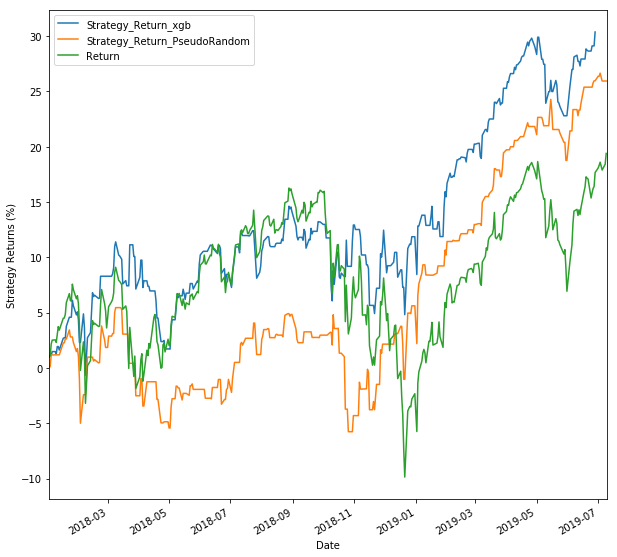

In [122]:
DfXGB['Strategy_Return_xgb'] = DfXGB.Return * DfXGB.Predicted_Signal_xgb
DfXGB['Strategy_Return_PseudoRandom'] = Df.Return * np.random.random_integers(low=0, high=1, size=Df.Return.shape[0])
DfXGB[['Strategy_Return_xgb','Strategy_Return_PseudoRandom','Return']]['2018':].cumsum().plot(figsize=(10,10))
plt.ylabel("Strategy Returns (%)")
plt.show()